# Building a 1-dimensional surrogate

ICERM Workshop: Statistical Methods for the Detection, Classification, and Inference of Relativistic Objects

Date: 11/18/2020

Author: Scott Field

**Note**: In addition to the usual Python libraries, you will need rompy. And optionally lal and lalsimulation

## Note on packages....

1) Don't have rompy? Get it now from https://bitbucket.org/chadgalley/rompy (Python 2)

```bash
>>> git clone git@bitbucket.org:chadgalley/rompy.git
```

and since its pure-python, you can install it by simply adding rompy to your PYTHONPATH variable or, from this notebook,

```
import sys
sys.path.append("/path/to/rompy/")
```

Or (new way!) install forked-rompy from pip


```bash
>>> pip install forked-rompy
```


2) Don't have lal and lalsimulation? For the purposes of this notebook, you can instead use pre-made data (relevant commands are described later on).

## Session goal...

This notebook describes how to build a simple 1-dimensional surrogate model of your favorite 1-dimensional gravitational-wave model:

\begin{align*}
h(t, \theta, \phi; q) & = h_+(t, \theta, \phi; q) - \mathrm{i} h_x(t, \theta, \phi; q) \\
& = \sum_{\ell=2}^{\infty} \sum_{m=-\ell}^{\ell} h^{\ell m}(t;q) {}_{-2}Y_{\ell m} \left(\theta, \phi \right) \, ,
\end{align*}

Where $\theta$ and $\phi$ are angles for the direction of propagation away from the source, $q$ is the mass ratio and  ${}_{-2}Y_{\ell m}$ are the harmonic functions.

We will build a surrogte for the (2,2)-mode

$$h^{22}(t;q)$$


Our building strategy will be completely new! We will mix different methods according to:

* Align waveforms in time, but not phase
* SVD basis
* Empirical interpolant representation
* Splines to approximate the real/imaginary parts of h(T;q) for T fixed and q variying

While each part has been reported in the litterature (being a mixture of methods considered in https://arxiv.org/abs/1402.4146 and https://arxiv.org/abs/1308.3565), this combination hasn't been considered before. This illustrates the flexability of surrogate building.

In [4]:
# import the usual suspects
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Step 0: evaluating the model

In this first lesson we check that lalsimulation is installed, and you are able to evaluate the EOBNRv2 model.

If you do not have lalsimulation installed, you can skip this 0th step altogether.

In [5]:
import lalsimulation as LS
import lal

print(LS.__version__) # Make sure your version is >= 2.0

2.3.0


In [6]:
# define a simplified interface to the EOB model

def Mq_to_m1m2(M, q):
  """Convert total mass, mass ratio pair to m1, m2"""
  m2 = M/(1.+q)
  m1 = M-m2
  return m1, m2

def EOBNRv2_LAL_modes(Mtot=80.0,q=1.0,dt=1.0/2048.,fmin=10.0,Dist=1.0,ell=2,emm=2):
  """ Simplified inferface to EOBNRv2 mode.

      INPUT
      =====
      Dist -- distance in megaparsecs.
      Mtot -- total mass in solar masses"""

  Dist = Dist * 1e6 *lal.PC_SI
  Mtot = Mtot * lal.MSUN_SI

  M1,M2  = Mq_to_m1m2(Mtot,q)

  h      = LS.SimInspiralChooseTDMode(deltaT=dt,m1=M1,m2=M2,
                                      f_min=fmin,f_ref=0.0,r=Dist,
                                      lambda1=0.0,lambda2=0.0,waveFlags=None,
                                      nonGRparams=None,amplitudeO=0,
                                      phaseO=7,l=ell,m=emm,approximant=LS.EOBNRv2)

  times = np.arange(np.size(h.data.data))*h.deltaT

  return times, h.data.data


In [7]:
t, h = EOBNRv2_LAL_modes(80.0,1.0,1.0/2048.0,10.0,1.0,2,2)

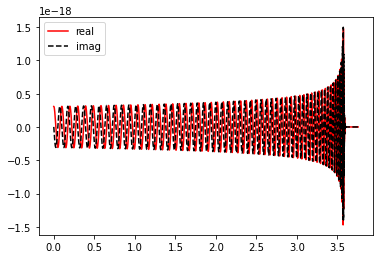

In [8]:
plt.plot(t,np.real(h),'r',label = "real")
plt.plot(t,np.imag(h),'k--',label = "imag")
plt.legend()

# Step 1: Building the training set



There are potentially many reasonable ways to construct a training set defined on the training region

$$q \in [1, 2]$$

and we will use the easiest of all: uniformly spaced grid

In [9]:
# global settings that control the training set
dt = 1.0/2048.
train_samples = 100 # more waveforms, better models

In [10]:
def training_set_generator(N,verbose=False):
    """Generate N training samples from q in [1,2]"""
    qs = np.linspace(1.0,2.0,N)
    training_data = []
    for q in qs:
        t,h = EOBNRv2_LAL_modes(Mtot=80.0,q=q,dt=dt,fmin=10.0,Dist=1.0,ell=2,emm=2)
        training_data.append(h)
        if verbose:
            print('length of h is %i'%len(h))
    return qs, training_data

In [11]:
# generating training data
qs, training_data = training_set_generator(train_samples, verbose=True)

# if you don't have lal, instead do:
#qs = np.loadtxt("data/1D_EOBNRv2/q_values_training.txt")
#training_data = np.load("data/1D_EOBNRv2/training_data.npy",allow_pickle=True,encoding="bytes")

length of h is 7691
length of h is 7692
length of h is 7692
length of h is 7692
length of h is 7694
length of h is 7696
length of h is 7697
length of h is 7699
length of h is 7702
length of h is 7704
length of h is 7707
length of h is 7710
length of h is 7714
length of h is 7716
length of h is 7720
length of h is 7725
length of h is 7728
length of h is 7733
length of h is 7738
length of h is 7742
length of h is 7748
length of h is 7753
length of h is 7758
length of h is 7764
length of h is 7768
length of h is 7774
length of h is 7780
length of h is 7786
length of h is 7793
length of h is 7799
length of h is 7806
length of h is 7813
length of h is 7820
length of h is 7828
length of h is 7835
length of h is 7843
length of h is 7850
length of h is 7858
length of h is 7866
length of h is 7874
length of h is 7882
length of h is 7890
length of h is 7898
length of h is 7907
length of h is 7915
length of h is 7924
length of h is 7933
length of h is 7942
length of h is 7951
length of h is 7961


## Interlude I: preparing waveform data -- common durations

For surrogate modeling to work, we need all of the waveforms to be of the same duration/length. From whats shown above, this is not the case. We need to modify our waveform data to fix this problem

In [12]:
def common_time_grid(training_data):
    """
    INPUT
    =====
    training_data: set of training waveforms 
    
    OUTPUT
    ======
    training data as a numpy array, padding with zeros as 
    necessary such that all waveforms are of the same length"""
    
    longest_waveform = 0
    for h in training_data:
        length = len(h)
        if length > longest_waveform:
            longest_waveform = length
            
    print("longest waveform size = %i"%longest_waveform)
        
    padded_training_data = []
    for h in training_data:
        nZeros = longest_waveform - len(h)
        h_pad = np.append(h, np.zeros(nZeros))
        padded_training_data.append(h_pad)
        
    times = np.arange(longest_waveform)*dt
    
    padded_training_data = np.vstack(padded_training_data).transpose()
    
    return times, padded_training_data

In [13]:
times, training_data = common_time_grid(training_data)

longest waveform size = 8515


(3.0, 4.2)

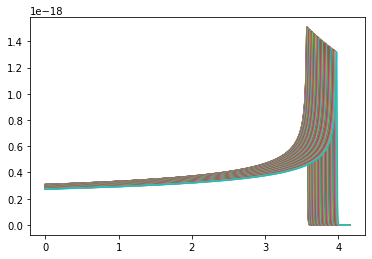

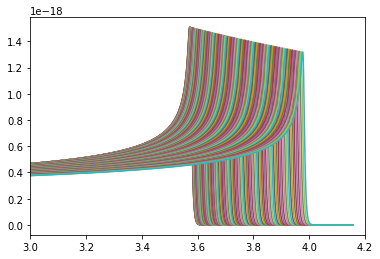

In [14]:
plt.figure(1)
plt.plot(times,np.abs(training_data))

plt.figure(2)
plt.plot(times,np.abs(training_data))
plt.xlim([3,4.2])

## Interlude II: preparing waveform data -- temporal alignment

For surrogate modeling to work, the model should change as little as possible as the parameter is varied. Unfortunately, thats not the case here. A simulation-dependent time-shift will align the peaks. 

Lets align all of the waveform peaks, using the shortest waveform as the reference one.

In [15]:
def get_peak(t, h):
  """Get argument and values of t and h at maximum value of |h| on a discrete grid. """
  arg = np.argmax(np.abs(h))
  return [arg, t[arg], h[arg]]

def get_peaks(t,training_set):
    """ Find the index of each waveform's peak in the entire training set. """
    time_peak_arg = []
    for i in range(train_samples):
        [arg, t_peak, h_peak] = get_peak(times,training_set[:,i]) # i^th training sample
        time_peak_arg.append(arg)
        print("Waveform %i with t_peak = %f"%(i,t_peak))
    print(time_peak_arg)
    return time_peak_arg

def align_peaks(times, training_set):
    """ Peak align a set of waveforms. The shortest waveform is used as the reference
    one."""
    
    time_peak_arg = get_peaks(times,training_set)
    
    min_arg = min(time_peak_arg)
    aligned_training_set=[]
    for i in range(train_samples):
        offset = time_peak_arg[i] - min_arg
        print("offset value of %i"%offset)
        h_aligned = training_set[offset:,i]
        aligned_training_set.append(h_aligned)
        
    t, training_data_aligned = common_time_grid(aligned_training_set)
    return training_data_aligned

In [16]:
training_data_aligned = align_peaks(times, training_data)

Waveform 0 with t_peak = 3.572266
Waveform 1 with t_peak = 3.572266
Waveform 2 with t_peak = 3.572754
Waveform 3 with t_peak = 3.572754
Waveform 4 with t_peak = 3.573242
Waveform 5 with t_peak = 3.574219
Waveform 6 with t_peak = 3.574707
Waveform 7 with t_peak = 3.575684
Waveform 8 with t_peak = 3.577148
Waveform 9 with t_peak = 3.578613
Waveform 10 with t_peak = 3.579590
Waveform 11 with t_peak = 3.581055
Waveform 12 with t_peak = 3.583008
Waveform 13 with t_peak = 3.584473
Waveform 14 with t_peak = 3.586426
Waveform 15 with t_peak = 3.588379
Waveform 16 with t_peak = 3.590332
Waveform 17 with t_peak = 3.592773
Waveform 18 with t_peak = 3.594727
Waveform 19 with t_peak = 3.596680
Waveform 20 with t_peak = 3.599609
Waveform 21 with t_peak = 3.602051
Waveform 22 with t_peak = 3.604492
Waveform 23 with t_peak = 3.607422
Waveform 24 with t_peak = 3.610352
Waveform 25 with t_peak = 3.613281
Waveform 26 with t_peak = 3.616211
Waveform 27 with t_peak = 3.619629
Waveform 28 with t_peak = 3.62

(3.565, 3.585)

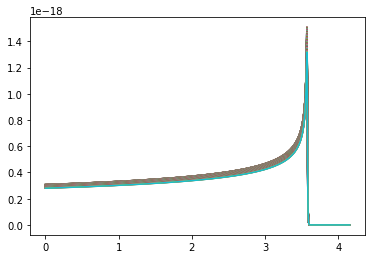

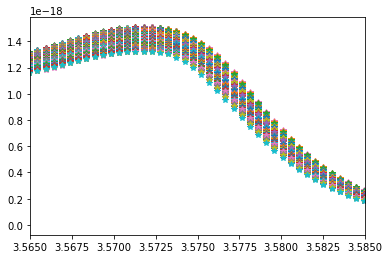

In [17]:
plt.figure(1)
plt.plot(times,np.abs(training_data_aligned))

plt.figure(2)
plt.plot(times,np.abs(training_data_aligned),'*')
plt.xlim([3.565,3.585])

In [18]:
# sanity check (its hard to tell from figure that these peaks are aligned)
get_peaks(times,training_data_aligned)

Waveform 0 with t_peak = 3.572266
Waveform 1 with t_peak = 3.572266
Waveform 2 with t_peak = 3.572266
Waveform 3 with t_peak = 3.572266
Waveform 4 with t_peak = 3.572266
Waveform 5 with t_peak = 3.572266
Waveform 6 with t_peak = 3.572266
Waveform 7 with t_peak = 3.572266
Waveform 8 with t_peak = 3.572266
Waveform 9 with t_peak = 3.572266
Waveform 10 with t_peak = 3.572266
Waveform 11 with t_peak = 3.572266
Waveform 12 with t_peak = 3.572266
Waveform 13 with t_peak = 3.572266
Waveform 14 with t_peak = 3.572266
Waveform 15 with t_peak = 3.572266
Waveform 16 with t_peak = 3.572266
Waveform 17 with t_peak = 3.572266
Waveform 18 with t_peak = 3.572266
Waveform 19 with t_peak = 3.572266
Waveform 20 with t_peak = 3.572266
Waveform 21 with t_peak = 3.572266
Waveform 22 with t_peak = 3.572266
Waveform 23 with t_peak = 3.572266
Waveform 24 with t_peak = 3.572266
Waveform 25 with t_peak = 3.572266
Waveform 26 with t_peak = 3.572266
Waveform 27 with t_peak = 3.572266
Waveform 28 with t_peak = 3.57

[7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316,
 7316]

# Step 2: Building a basis

The next step is to compress the model by finding a basis. The greedy algorithm and singular value decomposition (SVD) are two popular approaches. Here we will use the SVD, which is already coded up in numpy. 

The greedy (reduced basis) algorithm is a often used alternative

### background on the SVD

You can think of a SVD as an algorithm which identifies the "most important" columns of a matrix. A column is "important" if the other columns of the matrix can be written as a linear combination of the important ones. 

Suppose you have a 10000-by-100 matrix, ${\bf A}$, and you discover that all 100 columns can be written as a linear combination of just 2 columns. That would be great -- you could compress the matrix by storing just 2 columns! This is what the SVD provides, and how it can  be used to approximate a matrix ${\bf A}$. 

Since the training set of waveforms is really just a matrix, we can use the SVD to compress the training set. 

For our puproses, just keep in mind that the most important columns (the basis) are columns of u and the $i^{th}$ singluar values, $s_i$, assigns a weight to how important the $i^{th}$ column is. 

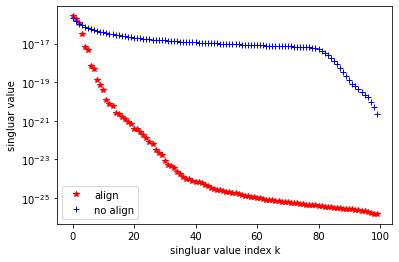

In [19]:
# first, lets check the claim that peak-aligned training sets are easier to approximate.
# From the above discussion, faster decaying singular values means the matrix/model is easier
# to compress
u, s_no_align, vh = np.linalg.svd(training_data, full_matrices=False)
u, s, vh          = np.linalg.svd(training_data_aligned, full_matrices=False)
plt.semilogy(range(train_samples),s,'r*',label='align')
plt.semilogy(range(train_samples),s_no_align,'b+',label='no align')
plt.ylabel('singluar value')
plt.xlabel('singluar value index k')
plt.legend(loc=3)

/home/balzani57/pool/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/balzani57/pool/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/balzani57/pool/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/balzani57/pool/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


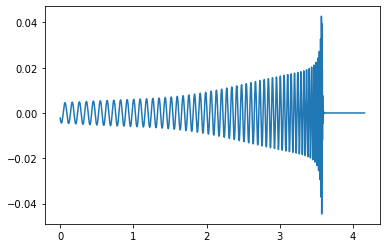

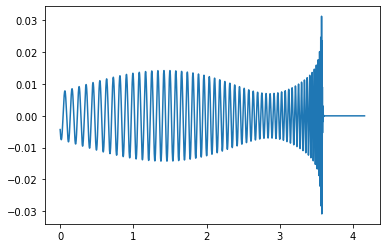

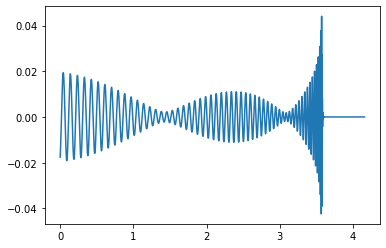

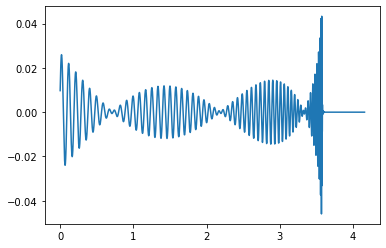

In [20]:
# plot the top 4 singular vectors -- these are the 4 most
# important features according to the SVD
# if you had to use only 4 columns to represent the all training set waveforms, 
# these would be the 4 to use. 
for i in range(4):
    plt.figure(i)
    plt.plot(times,u[:,i])

## Interlude I:  a waveform-compression tool

We can immediately use the first $n$ basis to compute 

$$h(t;q) \approx \sum_{i=1}^n  c_i (q) u_i(t)$$


where $u_i(t)$ is the $i^{th}$ basis vector and $c_i (q)$ are the coefficients of the representation of $h(t;q)$ in the approximation space span$\{u_i\}_{i=1}^n$. Since $u_i$ are orthonormal, the coefficient $c_i (q)$ is found by takind the inner produce of $h(t;q)$ with $u_i$

In [21]:
# Decide on how many column vectors to use as the basis
basis_size = 7 # More vectors -> more accuracy but also more computational cost 
basis_set  = u[:,0:basis_size]

/home/balzani57/pool/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/balzani57/pool/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


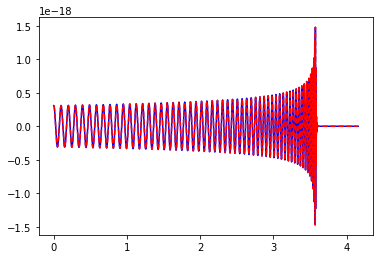

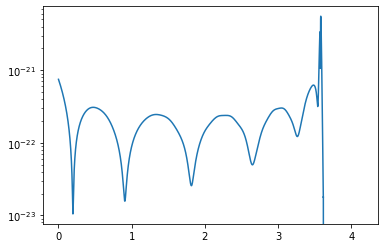

In [22]:
# Select a waveform to approximate 
h_i = training_data_aligned[:,0]

# compute its representation in the linear space defined by the span of the basis set
proj_coeffs = np.dot(basis_set.transpose(), h_i.conjugate()) 
h_approx = np.dot(basis_set, proj_coeffs.transpose())
h_approx = h_approx.transpose()

# plot the original waveform, its compressed version, and the error
plt.figure(1)
plt.plot(times,h_i,'blue')
plt.plot(times,h_approx,'r--')

plt.figure(2)
wave_err = np.abs(h_i - h_approx)
plt.semilogy(times,wave_err)

## Short exercise 1

Explore the relationshiop between the singular value spectrum, s, and the waveform error.

Task: Select some waveform from your training set to approximate. Compute the approximation error vs # of SVD basis. Plot this error along with the singular values. What do you notice?

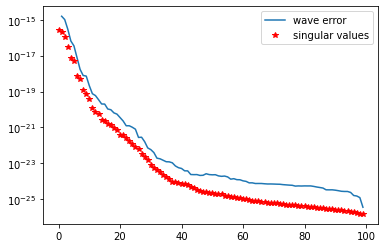

In [23]:
# Select a waveform to approximate 
h_i = training_data_aligned[:,0]

errors = []
bss = range(1,100)
for bs in bss:
    basis_set_local  = u[:,0:bs]

    # compute its representation in the linear space defined by the span of the basis set
    proj_coeffs = np.dot(basis_set_local.transpose(), h_i.conjugate()) 
    h_approx = np.dot(basis_set_local, proj_coeffs.transpose())
    h_approx = h_approx.transpose()
    
    wave_err = np.abs(h_i - h_approx)
    errors.append(np.sum(wave_err))
    
# plot the original waveform, its compressed version, and the error
plt.semilogy(bss,errors,label='wave error')
plt.semilogy(range(train_samples),s,'r*',label='singular values')
plt.legend()

# Step 3: An empirical interpolant representation 

As an alternative to projecting onto the basis set, an empirical interpolant can be used. The main idea is to trade the $n$ peices of information, the projection coefficients $c_i$, for direct waveform evaluations.

Given $n$ basis, there (usually) exists $n$ times $\{T_i\}_{i=1}^n$ for which the set of numbers
$$\{ c_i (q) \}_{i=1}^n \Longleftrightarrow \{ h(T_i;q) \}_{i=1}^n$$
contains equivalent information in the sense that 

$$ h (t;q) \approx \sum_{i=1}^n  c_i (q) u_i(t) \approx \sum_{i}^n h(T_i;q) B_i(t)$$

where $B_i(t)$ are just linear combinations of $u_i(t)$ (ie the approximation space, the span of the basis, is unchanged). 

In [24]:
# recommened to "pip install forked-rompy" (https://pypi.org/project/forked-rompy/)
import rompy as rp

# if getting original source code: https://bitbucket.org/chadgalley/rompy/
# Import RomPy. if its not in your PYTHONPATH, add it now
#import sys
#sys.path.append('/home/balzani57/Repo/GitRepos/Codes')

In [25]:
eim = rp.EmpiricalInterpolant(basis_set.transpose(), verbose=True) # Note the transpose

('\nStep', '\t', 'Nodes')
(1, '\t', 7316)
(2, '\t', 3759)
(3, '\t', 216)
(4, '\t', 5941)
(5, '\t', 7272)
(6, '\t', 1761)
(7, '\t', 7331)


In [26]:
# the most important pieces of information are the interpolation times T_i and the basis B_i
eim_indicies = eim.indices
B = eim.B

(3.4, 3.6)

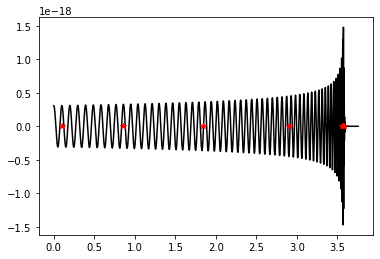

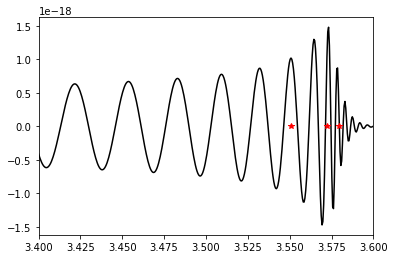

In [27]:
# Lets see what time the empirical inteprolation method has discovered as most important:
T_eim = times[eim_indicies]

plt.figure(1)
plt.plot(t,np.real(h),'k')
plt.plot(T_eim,np.zeros_like(T_eim),'r*')

plt.figure(2)
plt.plot(t,np.real(h),'k')
plt.plot(T_eim,np.zeros_like(T_eim),'r*')
plt.xlim([3.4,3.6])

Claim: To compute the waveform $h(t;q)$ at any time, we only need to know the waveform's value at the times $T_i$. 

Lets check this...

/home/balzani57/pool/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/balzani57/pool/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


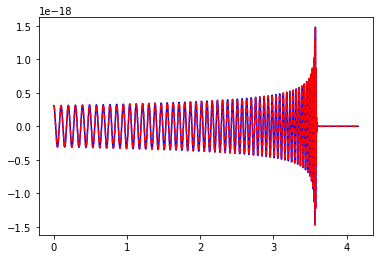

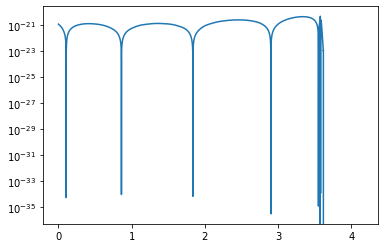

In [28]:
# Select a waveform to approximate 
h_i = training_data_aligned[:,0]

# compute its empirical interpolant representation 
h_eim =  h_i[eim_indicies]
h_approx = np.dot(B.transpose(), h_eim)

# plot the original waveform, its empirically interpolated version, and the error
plt.figure(1)
plt.plot(times,h_i,'blue')
plt.plot(times,h_approx,'r--')

plt.figure(2)
plt.semilogy(times,np.abs(h_i - h_approx))

## Short exercise 2

Explain why the error somtimes drops to numerical zero. Provide numerical evidence to justify your answer!

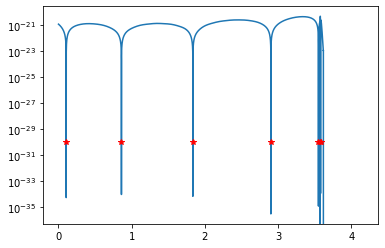

In [29]:
# The empirical interpolant interpolates the data. So the errors will be zero at the EIM nodes

plt.figure(2)
plt.semilogy(times,np.abs(h_i - h_approx))
plt.semilogy(T_eim,np.ones_like(T_eim)*1.e-30,'r*')

# Step 4: Parametric fits

We are almost ready to complete our surrogate model! If we could evaluate the few functions $h(T_i;q)$ at any q, then we would be done. So what remains is finding a way to predict their values.

Here one often uses interpolation (e.g. polynomials, splines, etc), fits/regressions, or, more recently, Gaussian process regression. One could imagine many other resonable choices too.

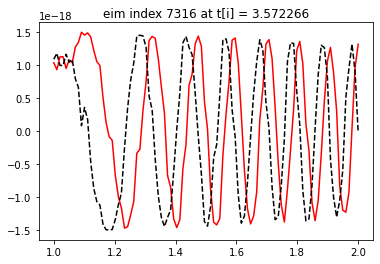

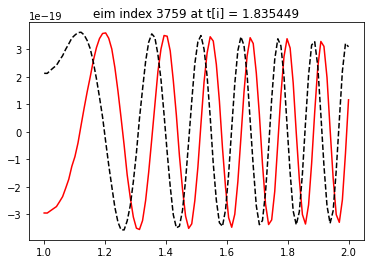

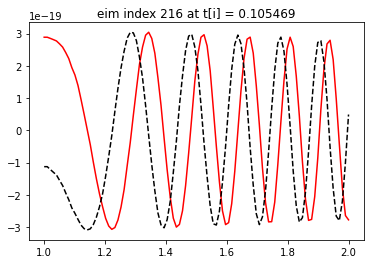

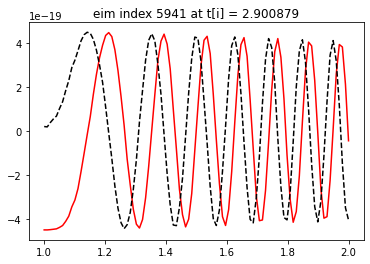

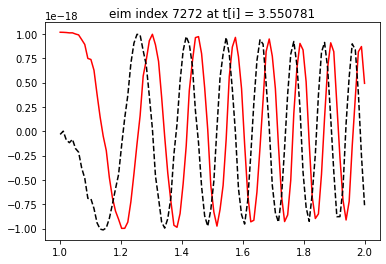

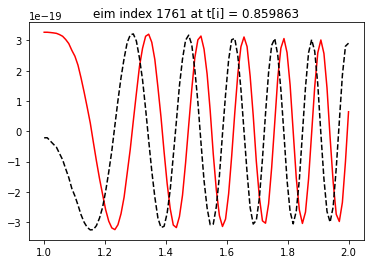

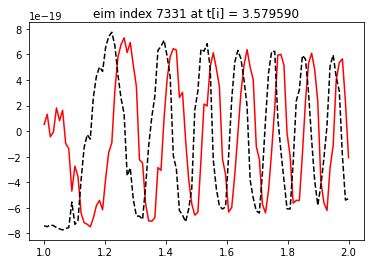

In [30]:
# First, view the data we need to fit
h_training_eim = training_data_aligned[eim_indicies,:]

for counter, i in enumerate(eim_indicies):
    plt.figure(counter)
    plt.title("eim index %i at t[i] = %f"%(i,times[i]))
    plt.plot(qs,np.real(h_training_eim[counter,:]),'r',label='real' )
    plt.plot(qs,np.imag(h_training_eim[counter,:]),'k--',label='imag' )

## Interlude: dealing with hard-to-aproximate functions

Evidently, these functions have a significant amount of struture in $q$. There are a few strategies for dealing with this:

1) One could look for adventageous decompositions of the data, for example,

$$h(T_i;q) = A(T_i;q) \exp\left(-\mathrm{i} \phi(T_i;q) \right)$$

since the amplitude, $A$, and phase, $\phi$ are expected to be "borring" functions of $q$

2) One could align the phases at some reference time. This would happen early in the surrogate building process, say step 1 after temporal alignment

3) One could brute force it, by using splines with dense grids

... we will follow 3

In [31]:
from scipy.interpolate import splrep, splev

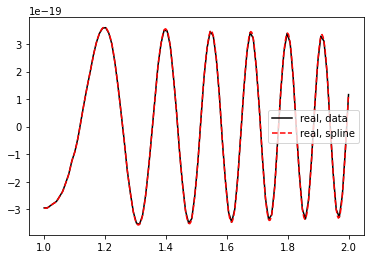

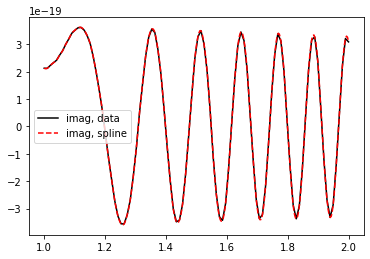

In [32]:
# lets first show how this works on a data piece 
eim_indx = 1
h_eim_real_spline = splrep(qs, np.real(h_training_eim[eim_indx,:]),k=2) # degree 2
h_eim_imag_spline = splrep(qs, np.imag(h_training_eim[eim_indx,:]),k=2) # degree 2

q_dense = np.linspace(min(qs),max(qs),300)

plt.figure(1)
plt.plot(qs,np.real(h_training_eim[eim_indx,:]),'k',label ='real, data')
plt.plot(q_dense,splev(q_dense,h_eim_real_spline),'r--',label ='real, spline')
plt.legend()

plt.figure(2)
plt.plot(qs,np.imag(h_training_eim[eim_indx,:]),'k',label ='imag, data')
plt.plot(q_dense,splev(q_dense,h_eim_imag_spline),'r--',label ='imag, spline')
plt.legend()

In [33]:
# Now find the spline interpolant for all of the coefficients 
h_eim_real_spline = [splrep(qs, np.real(h_training_eim[i,:]),k=2) for i in range(len(eim_indicies))]
h_eim_imag_spline = [splrep(qs, np.imag(h_training_eim[i,:]),k=2) for i in range(len(eim_indicies))]

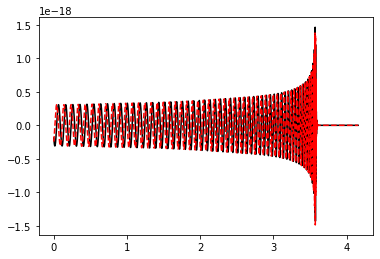

In [34]:
# The full surrogate can now be evaluated by evaluating the splines, and using the 
# empirical interpolation representation

q=1.2 # mass ratio value to predict now model for

h_eim = np.array([splev(q, h_eim_real_spline[j])  \
             + 1.0j*splev(q,h_eim_imag_spline[j]) for j in range(len(eim_indicies))])
h_approx = np.dot(B.transpose(), h_eim)

# plot the original waveform, its empirically interpolated version, and the error
plt.figure(1)
plt.plot(times,np.real(h_approx),'k')
plt.plot(times,np.imag(h_approx),'r--')

# Step 5: Full surrogate

We're basically done. 

Lets package up all the data to make it more user friendly. Then sanity test the model by comparing against the training data. Show its faster.

In [35]:
def surrogate(q):
    h_eim = np.array([splev(q, h_eim_real_spline[j])  \
             + 1.0j*splev(q,h_eim_imag_spline[j]) for j in range(len(eim_indicies))])
    h_approx = np.dot(B.transpose(), h_eim)
    return h_approx

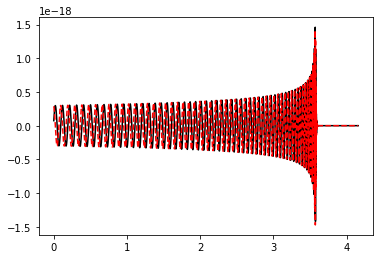

In [36]:
h_surr = surrogate(q=1.5)
plt.figure(1)
plt.plot(times,np.real(h_surr),'k')
plt.plot(times,np.imag(h_surr),'r--')

In [37]:
# timing experiment -- EOB model from LAL
%time qs, training_data = training_set_generator(train_samples)

CPU times: user 14.2 s, sys: 2.99 ms, total: 14.2 s
Wall time: 14.2 s


In [38]:
# timing experiment -- EOB surrogate model
%time surrogate_evals = np.array([surrogate(q) for q in qs]).transpose()

CPU times: user 94.7 ms, sys: 0 ns, total: 94.7 ms
Wall time: 16 ms


In [39]:
# accuracy as relative error in max norm
# here we compare the model against the training data
h_error = np.abs(training_data_aligned - surrogate_evals)
h_inf =  h_error.max(axis=0) / np.abs(training_data_aligned).max(axis=0)

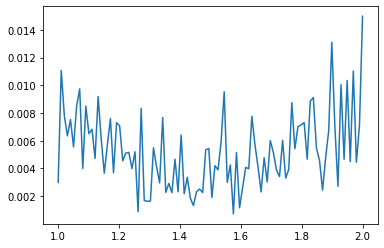

In [40]:
plt.plot(qs,h_inf)

# Going further

The surrogate model seems to be working well. Further directions to explore include...

* How do the errors compare against testing waveforms not used to train?
* What is the dominant source of model error? Do the errors get smaller as... the number of basis used is increased? The training set density is increased? Different order splines are used? The sampling rate dt is decreased? 